## Ref

+ Dynamic Matrix Factorization with Priors on Unknown Values
+ https://arxiv.org/pdf/1507.06452.pdf

### imports

In [1]:
import numpy as np
import csv
import random
import time
import copy
import pickle

### Load data

In [2]:
train = []
update = []
test = []

with open("movielens_offline_train.csv", newline = "") as f:
    rows = csv.reader(f)
    for row in rows:
        train.append(row)
        
with open("movielens_offline_test.csv", newline = "") as f:
    rows = csv.reader(f)
    for row in rows:
        test.append(row)

In [3]:
train[:5]

[['429', '22', '4.0', '828124615'],
 ['429', '150', '5.0', '828124615'],
 ['429', '161', '5.0', '828124615'],
 ['429', '165', '4.0', '828124615'],
 ['429', '218', '4.0', '828124615']]

In [4]:
test[:5]

[['429', '164', '3.0', '828124762'],
 ['191', '673', '5.0', '829760898'],
 ['99', '555', '4.0', '829828007'],
 ['35', '252', '4.0', '830940246'],
 ['468', '432', '2.0', '831400545']]

In [5]:
user_dict = {}
item_dict = {}
user_count = 0
item_count = 0

for row in train:
    if row[0] not in user_dict:
        user_dict[row[0]] = user_count
        user_count += 1
    if row[1] not in item_dict:
        item_dict[row[1]] = item_count
        item_count += 1
        
for row in test:
    if row[0] not in user_dict:
        user_dict[row[0]] = user_count
        user_count += 1
    if row[1] not in item_dict:
        item_dict[row[1]] = item_count
        item_count += 1

In [6]:
user_dict_2 = {}
item_dict_2 = {}

for user in user_dict:
    user_dict_2[user_dict[user]] = user
for item in item_dict:
    item_dict_2[item_dict[item]] = item

In [7]:
for row in train:
    row[0] = user_dict[row[0]]
    row[1] = item_dict[row[1]]
    row[2] = float(row[2])
    
for row in test:
    row[0] = user_dict[row[0]]
    row[1] = item_dict[row[1]]
    row[2] = float(row[2])

In [8]:
train[:5]

[[0, 0, 4.0, '828124615'],
 [0, 1, 5.0, '828124615'],
 [0, 2, 5.0, '828124615'],
 [0, 3, 4.0, '828124615'],
 [0, 4, 4.0, '828124615']]

In [9]:
test[:5]

[[0, 365, 3.0, '828124762'],
 [2, 521, 5.0, '829760898'],
 [3, 156, 4.0, '829828007'],
 [5, 34, 4.0, '830940246'],
 [6, 13, 2.0, '831400545']]

### data size

In [10]:
n_user = len(user_dict)
n_item = len(item_dict)
n_rating = len(train)

print("number of ratings:", n_rating)
print("n_user:", n_user)
print("n_item:", n_item)

number of ratings: 100226
n_user: 610
n_item: 9724


### number of training and updating

In [11]:
n_train = len(train)
n_test = len(test)

print("n_train:", n_train)
print("n_test:", n_test)

n_train: 100226
n_test: 610


### construct rating matrix

In [12]:
ratings = []
zeros = np.zeros(n_item)

for _ in range(n_user):
    ratings.append(zeros.copy())
    
for i in range(n_train):
    ratings[train[i][0]][train[i][1]] = 1.0

In [13]:
ratings[0][:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### list rated movies for each user & for each movie

In [14]:
rate_lists_user = []
rate_lists_item = []

for i in range(n_user):
    tmp = []
    for j in range(n_item):
        if ratings[i][j] > 0.1:
            tmp.append(j)
    rate_lists_user.append(tmp.copy())
    
for i in range(n_item):
    tmp = []
    for j in range(n_user):
        if ratings[j][i] > 0.1:
            tmp.append(j)
    rate_lists_item.append(tmp.copy())

In [15]:
len(rate_lists_user[0])

57

In [16]:
len(rate_lists_item[0])

35

### initialize user and item vectors

In [17]:
user_vecs = []
item_vecs = []
dim = 100

def noise(dim):
    return np.random.uniform(-1, 1, dim)

for i in range(n_user):
    user_vecs.append(noise(dim))
for i in range(n_item):
    item_vecs.append(noise(dim))

In [18]:
user_vecs[0]

array([ 0.16543598,  0.42040038, -0.72956529,  0.91314608, -0.35204616,
        0.08962635,  0.01434623,  0.22756327,  0.2563137 ,  0.83743456,
       -0.15319947,  0.37150256,  0.36158229, -0.02731115, -0.1328144 ,
        0.90399469,  0.32778973,  0.91458163,  0.69388054, -0.44689616,
       -0.07789735, -0.45312022, -0.10886928,  0.53952038, -0.75047714,
       -0.44747907, -0.24903049,  0.00998608,  0.57722713, -0.07316625,
        0.08683585, -0.11967665,  0.65375798,  0.58304038, -0.1470068 ,
        0.62092766, -0.64027034, -0.37709201, -0.50375797,  0.94148027,
       -0.84098036,  0.4460965 , -0.72136175, -0.93645051, -0.431411  ,
        0.97304801,  0.96689519, -0.8817354 , -0.18514673,  0.85686006,
       -0.68637553,  0.07038211,  0.47953772,  0.18407056,  0.88599497,
       -0.18064832, -0.59928211, -0.96399679,  0.01393502,  0.09561664,
       -0.0263926 , -0.06978904,  0.3077995 ,  0.18731418, -0.27938881,
        0.35903129, -0.16037093,  0.65309509,  0.14390194, -0.63

### calculate $S^{user}$ and $S^{item}$

In [19]:
def vec_mul(arr):
    l = len(arr)
    ret = []
    
    for i in range(l):
        tmp = np.zeros(l)
        for j in range(l):
            tmp[j] = arr[i] * arr[j]
        ret.append(tmp)
        
    return ret

In [20]:
def update_s_user():
    for i in range(n_user):
        s = vec_mul(user_vecs[i])
        for j in range(dim):
            s_user[j] += s[j]

def update_s_item():
    for i in range(n_item):
        s = vec_mul(item_vecs[i])
        for j in range(dim):
            s_item[j] += s[j]

### gradient of loss

In [21]:
def dot(a, b):
    ret = 0.0
    for i in range(len(a)):
        ret += a[i] * b[i]
    return ret

def sign(x):
    if x >= 0:
        return 1
    else:
        return -1

def gradient_user(i, alpha, lmd):
    ret = np.zeros(dim)
    # 2 * \alpha * w_i * S^h
    for j in range(dim):
        ret[j] += 2 * alpha * dot(user_vecs[i], s_item[j])
    # \lambda * sign(w_i)
    for j in range(dim):
        ret[j] += lmd * sign(user_vecs[i][j])
    # -2 * \sum{h_j}
    for j in range(len(rate_lists_user[i])):
        no = rate_lists_user[i][j]
        rate = ratings[i][no]
        scalar = rate - (1-alpha) * dot(user_vecs[i], item_vecs[no])
        scalar *= -2
        ret += scalar * item_vecs[no]
    return ret

def gradient_item(i, alpha, lmd):
    ret = np.zeros(dim)
    # 2 * \alpha * h_i * S^w
    for j in range(dim):
        ret[j] += 2 * alpha * dot(item_vecs[i], s_user[j])
    # \lambda * sign(h_i)
    for j in range(dim):
        ret[j] += lmd * sign(item_vecs[i][j])
    # -2 * \sum{w_j}
    for j in range(len(rate_lists_item[i])):
        no = rate_lists_item[i][j]
        rate = ratings[no][i]
        scalar = rate - (1-alpha) * dot(item_vecs[i], user_vecs[no])
        scalar *= -2
        ret += scalar * user_vecs[no]
    return ret

def gradient_user_u(i, alpha, lmd):
    ret = np.zeros(dim)
    # 2 * \alpha * w_i * S^h
    for j in range(dim):
        ret[j] += 2 * alpha * dot(user_vecs_u[i], s_item_u[j])
    # \lambda * sign(w_i)
    for j in range(dim):
        ret[j] += lmd * sign(user_vecs_u[i][j])
    # -2 * \sum{h_j}
    for j in range(len(rate_lists_user_u[i])):
        no = rate_lists_user_u[i][j]
        rate = ratings_u[i][no]
        scalar = rate - (1-alpha) * dot(user_vecs_u[i], item_vecs_u[no])
        scalar *= -2
        ret += scalar * item_vecs_u[no]
    return ret

def gradient_item_u(i, alpha, lmd):
    ret = np.zeros(dim)
    # 2 * \alpha * h_i * S^w
    for j in range(dim):
        ret[j] += 2 * alpha * dot(item_vecs_u[i], s_user_u[j])
    # \lambda * sign(h_i)
    for j in range(dim):
        ret[j] += lmd * sign(item_vecs_u[i][j])
    # -2 * \sum{w_j}
    for j in range(len(rate_lists_item_u[i])):
        no = rate_lists_item_u[i][j]
        rate = ratings_u[no][i]
        scalar = rate - (1-alpha) * dot(item_vecs_u[i], user_vecs_u[no])
        scalar *= -2
        ret += scalar * user_vecs_u[no]
    return ret

### hyperparameters

In [22]:
lmd = 0.01
alpha = 0.035
rho = alpha * (n_user*n_item - n_train) / n_train
EPOCH = 60
lr = 0.001 # the paper use line search, but setting learning rate is good enough

print("lambda:", lmd)
print("alpha:", alpha)
print("rho:", rho)
print("learning rate:", lr)

lambda: 0.01
alpha: 0.035
rho: 2.036392652605113
learning rate: 0.001


### train

In [23]:
def update_user(i, scalar):
    mat = vec_mul(user_vecs[i])
    for j in range(dim):
        s_user[j] += scalar * mat[j]
    return

def update_item(i, scalar):
    mat = vec_mul(item_vecs[i])
    for j in range(dim):
        s_item[j] += scalar * mat[j]
    return

def update_user_u(i, scalar):
    mat = vec_mul(user_vecs_u[i])
    for j in range(dim):
        s_user_u[j] += scalar * mat[j]
    return

def update_item_u(i, scalar):
    mat = vec_mul(item_vecs_u[i])
    for j in range(dim):
        s_item_u[j] += scalar * mat[j]
    return

In [24]:
def cal_loss():
    ret = 0.0
    for i in range(n_user):
        for j in range(n_item):
            if ratings[i][j] > 0.1:
                residual = ratings[i][j] - dot(user_vecs[i], item_vecs[j])
                ret += residual ** 2
            else:
                residual = ratings[i][j] - dot(user_vecs[i], item_vecs[j])
                ret += alpha * (residual ** 2)
    sum_w = 0.0
    for i in range(n_user):
        for j in range(dim):
            sum_w += sign(user_vecs[i][j]) * user_vecs[i][j]
    for i in range(n_item):
        for j in range(dim):
            sum_w += sign(item_vecs[i][j]) * item_vecs[i][j]
    return ret + lmd * sum_w

def cal_loss_u():
    ret = 0.0
    for i in range(n_user):
        for j in range(n_item):
            if ratings_u[i][j] > 0.1:
                residual = ratings_u[i][j] - dot(user_vecs_u[i], item_vecs_u[j])
                ret += residual ** 2
            else:
                residual = ratings_u[i][j] - dot(user_vecs_u[i], item_vecs_u[j])
                ret += alpha * (residual ** 2)
    sum_w = 0.0
    for i in range(n_user):
        for j in range(dim):
            sum_w += sign(user_vecs_u[i][j]) * user_vecs_u[i][j]
    for i in range(n_item):
        for j in range(dim):
            sum_w += sign(item_vecs_u[i][j]) * item_vecs_u[i][j]
    return ret + lmd * sum_w

In [25]:
def cal_acc(n):
    predict = []
    rates = []
    error = 0.0

    for i in range(n):
        rates.append(1.0)
        predict.append(dot(user_vecs[test[i][0]], item_vecs[test[i][1]]))

    for i in range(n):
        error += abs(rates[i] - predict[i])

    return error / n

def cal_acc_u(n):
    predict = []
    rates = []
    error = 0.0

    for i in range(n):
        rates.append(1.0)
        predict.append(dot(user_vecs_u[test[i][0]], item_vecs_u[test[i][1]]))

    for i in range(n):
        error += abs(rates[i] - predict[i])

    return error / n

def cal_insample_acc(n):
    predict = []
    rates = []
    error = 0.0

    for i in range(n):
        rates.append(1.0)
        predict.append(dot(user_vecs[train[i][0]], item_vecs[train[i][1]]))

    for i in range(n):
        error += abs(rates[i] - predict[i])

    return error / n

def cal_insample_acc_u(n):
    predict = []
    rates = []
    error = 0.0

    for i in range(n):
        rates.append(1.0)
        predict.append(dot(user_vecs_u[train[i][0]], item_vecs_u[train[i][1]]))

    for i in range(n):
        error += abs(rates[i] - predict[i])

    return error / n

In [26]:
user_vecs = []
item_vecs = []
s_user = vec_mul(np.zeros(dim))
s_item = vec_mul(np.zeros(dim))

for i in range(n_user):
    user_vecs.append(noise(dim))
for i in range(n_item):
    item_vecs.append(noise(dim))

update_s_user()
update_s_item()

user_vecs_u = copy.deepcopy(user_vecs)
item_vecs_u = copy.deepcopy(item_vecs)
s_user_u = copy.deepcopy(s_user)
s_item_u = copy.deepcopy(s_item)

In [27]:
user_vecs = copy.deepcopy(user_vecs_u)
item_vecs = copy.deepcopy(item_vecs_u)
s_user = copy.deepcopy(s_user_u)
s_item = copy.deepcopy(s_item_u)

start_train_time = time.time()
cal_loss_time = 0.0
cal_acc_time = 0.0

losses = []
in_accs = []
out_accs = []

In [ ]:
for epoch in range(EPOCH):
    lis_user = list(range(n_user))
    lis_item = list(range(n_item))
    random.shuffle(lis_user)
    random.shuffle(lis_item)
    count = 0
    
    for i in lis_user:
        grad = gradient_user(i, alpha, lmd)
        update_user(i, -1)
        user_vecs[i] -= lr * grad
        update_user(i, 1)
        
        if count % 100 == 99:
            print("user:", count+1, "; in-sample error:", cal_insample_acc(n_test), "; out-sample error", cal_acc(n_test))
        count += 1
    
    count = 0
    
    for i in lis_item:
        grad = gradient_item(i, alpha, lmd)
        update_item(i, -1)
        item_vecs[i] -= lr * grad
        update_item(i, 1)
        
        if count % 100 == 99:
            print("item:", count+1, "; in-sample error:", cal_insample_acc(n_test), "; out-sample error", cal_acc(n_test))
        count += 1
    
    loss_time = time.time()
    # loss = 0
    # loss = cal_loss()
    # losses.append(loss)
    cal_loss_time += time.time() - loss_time
    
    acc_time = time.time()
    in_acc = cal_insample_acc(n_test)
    out_acc = cal_acc(n_test)
    in_accs.append(in_acc)
    out_accs.append(out_acc)
    cal_acc_time += time.time() - acc_time
    
    print("\nepoch", epoch, ": averge error(in):", in_acc, "; averge error(out):", out_acc, "\n")

print("total training time:", time.time()-start_train_time)
print("cal loss time:", cal_loss_time)
print("cal accuracy time:", cal_acc_time)

user: 100 ; in-sample error: 2.781315888157522 ; out-sample error 2.7385263283420516
user: 200 ; in-sample error: 2.656277855876597 ; out-sample error 2.60421027840175
user: 300 ; in-sample error: 2.461896376169439 ; out-sample error 2.4886528602197413
user: 400 ; in-sample error: 2.391279566246328 ; out-sample error 2.3587535313850982
user: 500 ; in-sample error: 2.3213129653613715 ; out-sample error 2.2357882937508804
user: 600 ; in-sample error: 1.956304156002879 ; out-sample error 2.094967149576474
item: 100 ; in-sample error: 1.9549257608695587 ; out-sample error 2.082941867672379
item: 200 ; in-sample error: 1.9538213033886924 ; out-sample error 2.0826023034889007
item: 300 ; in-sample error: 1.9534206317709035 ; out-sample error 2.0825083053362397
item: 400 ; in-sample error: 1.9527273232844813 ; out-sample error 2.0824987379172395
item: 500 ; in-sample error: 1.951786723594688 ; out-sample error 2.0823242280640963
item: 600 ; in-sample error: 1.948930922326579 ; out-sample erro

item: 9100 ; in-sample error: 1.860591650168078 ; out-sample error 2.0551877288432747
item: 9200 ; in-sample error: 1.860591650168078 ; out-sample error 2.0549279112260637
item: 9300 ; in-sample error: 1.8605438656261186 ; out-sample error 2.0546048524273868
item: 9400 ; in-sample error: 1.8599172857761306 ; out-sample error 2.054767401085918
item: 9500 ; in-sample error: 1.858534849323175 ; out-sample error 2.05470548785257
item: 9600 ; in-sample error: 1.85671750212629 ; out-sample error 2.0544937551033415
item: 9700 ; in-sample error: 1.8554907582998585 ; out-sample error 2.0541328323188255

epoch 0 : averge error(in): 1.8554907582998585 ; averge error(out): 2.0541675508079793 

user: 100 ; in-sample error: 1.7317130220086314 ; out-sample error 1.989389026357975
user: 200 ; in-sample error: 1.7091952805511665 ; out-sample error 1.9101688165615882
user: 300 ; in-sample error: 1.5949142421997056 ; out-sample error 1.835081585583218
user: 400 ; in-sample error: 1.574908088741021 ; out-

item: 8200 ; in-sample error: 1.3609792158529432 ; out-sample error 1.60973473179448
item: 8300 ; in-sample error: 1.3607010040200567 ; out-sample error 1.6097353893203368
item: 8400 ; in-sample error: 1.360048690026717 ; out-sample error 1.6096581116574131
item: 8500 ; in-sample error: 1.3597489675750212 ; out-sample error 1.6096083293205639
item: 8600 ; in-sample error: 1.358903093091816 ; out-sample error 1.6096590938060331
item: 8700 ; in-sample error: 1.3580977833881158 ; out-sample error 1.6095208001791625
item: 8800 ; in-sample error: 1.3575033155279166 ; out-sample error 1.609531095455086
item: 8900 ; in-sample error: 1.3570088571813894 ; out-sample error 1.6094530701474652
item: 9000 ; in-sample error: 1.356716845221982 ; out-sample error 1.6094536270152837
item: 9100 ; in-sample error: 1.356675024142878 ; out-sample error 1.609298308295128
item: 9200 ; in-sample error: 1.3562543661808006 ; out-sample error 1.6092427943387664
item: 9300 ; in-sample error: 1.3555884408905923 ; 

item: 7300 ; in-sample error: 1.0827751459611823 ; out-sample error 1.3324512393195145
item: 7400 ; in-sample error: 1.0827336658040694 ; out-sample error 1.3324504334050722
item: 7500 ; in-sample error: 1.0827421184751602 ; out-sample error 1.3324341473853318
item: 7600 ; in-sample error: 1.0827314371117394 ; out-sample error 1.3323931921100152
item: 7700 ; in-sample error: 1.0826534135415238 ; out-sample error 1.3322522308272682
item: 7800 ; in-sample error: 1.082406740950861 ; out-sample error 1.332241602166176
item: 7900 ; in-sample error: 1.082220834571405 ; out-sample error 1.3321933810464013
item: 8000 ; in-sample error: 1.0821633460611926 ; out-sample error 1.3321671259797785
item: 8100 ; in-sample error: 1.082108219471002 ; out-sample error 1.332133921622371
item: 8200 ; in-sample error: 1.0817118304327344 ; out-sample error 1.331951458027721
item: 8300 ; in-sample error: 1.081657059508108 ; out-sample error 1.3319664937391418
item: 8400 ; in-sample error: 1.0815950235529639 ;

item: 6400 ; in-sample error: 0.9350263231733696 ; out-sample error 1.1765717075151065
item: 6500 ; in-sample error: 0.9349784444719245 ; out-sample error 1.1765549299124096
item: 6600 ; in-sample error: 0.9349105310283782 ; out-sample error 1.1765641056179565
item: 6700 ; in-sample error: 0.9347532945630195 ; out-sample error 1.1765317923537508
item: 6800 ; in-sample error: 0.9346866883269064 ; out-sample error 1.1765037377748637
item: 6900 ; in-sample error: 0.9346724089665819 ; out-sample error 1.1764691760167005
item: 7000 ; in-sample error: 0.9346374556654434 ; out-sample error 1.1764602690541777
item: 7100 ; in-sample error: 0.9346157541726443 ; out-sample error 1.1764550223303931
item: 7200 ; in-sample error: 0.9346157541726443 ; out-sample error 1.1764431115995784
item: 7300 ; in-sample error: 0.9345530502712762 ; out-sample error 1.1764218512436102
item: 7400 ; in-sample error: 0.9344984606864051 ; out-sample error 1.1763747323765366
item: 7500 ; in-sample error: 0.93444194549

### test performance (out-sample)

In [ ]:
predict = []
rates = []

for i in range(n_test):
    rates.append(1.0)
    predict.append(dot(user_vecs[test[i][0]], item_vecs[test[i][1]]))

In [ ]:
for i in range(30):
    print("ans:", rates[i], "; predict:", predict[i])

In [ ]:
error = 0.0

for i in range(n_test):
    error += abs(rates[i] - predict[i])**2
    
print("averge error:", error / n_test)

In [ ]:
rating_list = [] # rating list for each user in training and updating data

for _ in range(n_user):
    rating_list.append([])

for row in train:
    rating_list[row[0]].append(row[1])

In [ ]:
not_rating_list = [] # rating list for each user not rating yet

for i in range(n_user):
    not_rating_list.append([])
    for j in range(n_item):
        if j not in rating_list[i]:
            not_rating_list[i].append(j)

In [ ]:
def take_value(elem):
    return elem[1]

top_n = []

for i in range(n_user):
    tmp = []
    for j in not_rating_list[i]:
        tmp.append([item_dict_2[j], dot(user_vecs[i], item_vecs[j])])
    tmp.sort(key = take_value)
    top_n.append(tmp[:100])

In [ ]:
with open("predict_offline.csv", "w", newline = "") as f:
    w = csv.writer(f)
    
    for i in range(n_user):
        row = []
        row.append(user_dict_2[i])
        for item in top_n[i]:
            row.append(item[0])
        w.writerow(row)

### test performance (in-sample)

In [43]:
predict = []
rates = []

for i in range(n_train):
    rates.append(1.0)
    predict.append(dot(user_vecs[train[i][0]], item_vecs[train[i][1]]))

In [44]:
for i in range(30):
    print("ans:", rates[i], "; predict:", predict[i])

ans: 1.0 ; predict: 0.5523556968748948
ans: 1.0 ; predict: 0.749103464834057
ans: 1.0 ; predict: 0.5649398089746898
ans: 1.0 ; predict: 0.775303885527917
ans: 1.0 ; predict: 0.34567286923268453
ans: 1.0 ; predict: 0.30218174439522916
ans: 1.0 ; predict: 0.38120942807761193
ans: 1.0 ; predict: 0.21369758870033392
ans: 1.0 ; predict: 0.4219488347352153
ans: 1.0 ; predict: 0.7294240961456246
ans: 1.0 ; predict: 0.42000137304405133
ans: 1.0 ; predict: 0.5453750622201439
ans: 1.0 ; predict: 0.4832363495896579
ans: 1.0 ; predict: 0.5398958290415744
ans: 1.0 ; predict: 0.6398563254804356
ans: 1.0 ; predict: 0.3370545480941776
ans: 1.0 ; predict: 0.7017265134612004
ans: 1.0 ; predict: 0.6524525456189196
ans: 1.0 ; predict: 0.6526618537152536
ans: 1.0 ; predict: 0.4555582244692692
ans: 1.0 ; predict: 0.583931460216683
ans: 1.0 ; predict: 0.45311413546391627
ans: 1.0 ; predict: 0.42726126844832596
ans: 1.0 ; predict: 0.4064266406365496
ans: 1.0 ; predict: 0.24745205171367918
ans: 1.0 ; predict: 

In [45]:
error = 0.0

for i in range(n_train):
    error += abs(rates[i] - predict[i])**2
    
print("averge error:", error / n_train)

averge error: 0.40141935283181496


### plot

In [46]:
import matplotlib.pyplot as plt

In [ ]:
# plt.plot(losses)
# plt.xlabel("epoch")
# plt.ylabel("loss")
# plt.show()

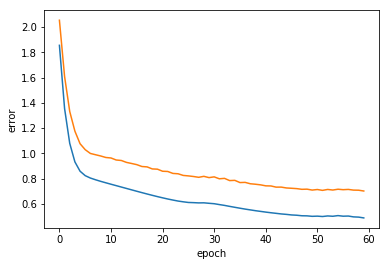

In [47]:
plt.plot(in_accs)
plt.plot(out_accs)
plt.xlabel("epoch")
plt.ylabel("error")
plt.show()